In [75]:
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV
from surprise import SVD, NMF, KNNWithZScore, KNNWithMeans
from surprise import AlgoBase

from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline

import os
# import sys
import math
import statistics
import collections

import sklearn as sk
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import NMF, TruncatedSVD
import numpy as np
import pandas as pd

import random
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

import datetime
from datetime import datetime
from time import time
import timeit

import math

In [76]:
class RatingDataset:
    import numpy as np
    from scipy import sparse
    
    def __init__(self):
        self.rating_mat = None
        # self.time_mat = None
        self._data_file_path = ''
        
        # list of raw user_IDs (dataset IDs)
        self.items = []
        self.users = []
        self.item_n = 0
        self.user_n = 0
        
        # maps raw user_id to user_iid(or inner id)
        self.user_to_iid = {}
        # maps user inner id to dataset raw ID
        self.user_to_ID = {}
        # maps raw item_id (dataset) to item_iid(or inner id)
        self.item_to_iid = {}
        # maps item inner id to dataset raw ID
        self.item_to_ID = {}
        
        # list of triples of (item, rating, timestamp) for each user_iid. 
        # TODO: In case there were no Timestamp in the data, pairs of (item, rating) will be kept
        self.user_ratings = []
        # list of pair of (user, rating) for each item_iid
        self.item_ratings = []
        
        
    def __get_line_format_indices(self, line_format):
        # specifying the order of 'user, item, rating, timestamp' in each line 
        lf_sp = line_format.split(' ')
        # if len(lf_sp) != 4:
        #     raise Exception('''Bad line format!
        #     line_format should be space-separated and it should always specified by 
        #     "user item rating timestamp" with any order!''')
        user_idx = -1
        item_idx = -1
        rating_idx = -1
        # timestamp_idx = -1
        for c in range(len(lf_sp)):
            if lf_sp[c] == 'user':
                user_idx = c
            elif lf_sp[c] == 'item':
                item_idx = c
            elif lf_sp[c] == 'rating':
                rating_idx = c
            # elif lf_sp[c] == 'timestamp':
            #     timestamp_idx = c
            else:
                raise Exception('line_format must be exactly dictated by one of: (user/item/rating/timestamp) separated by sep!')
        
        # return user_idx, item_idx, rating_idx, timestamp_idx
        return user_idx, item_idx, rating_idx
    
    
    '''
        Read the rating data from file and parse it and then make the dataset.
    '''
    # def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating timestamp'):
    def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating'):
        
        # user_fmt_idx, item_fmt_idx, rating_fmt_idx, timestamp_fmt_idx = self.__get_line_format_indices(line_format)
        user_fmt_idx, item_fmt_idx, rating_fmt_idx = self.__get_line_format_indices(line_format)
        
        file = open(data_fn, 'r')
        
        # skip lines that are specified from input
        for _ in range(skip_lines):
            file.readline()
            
        # users list as in input file
        users_lin = []
        items_lin = []
        ratings_lin = []
        # timestamps_lin = []
        for l in file:
            lsp = l.split(sep)
            user_id = lsp[user_fmt_idx]
            item_id = lsp[item_fmt_idx]
            rating = float(lsp[rating_fmt_idx])
            # timestamp = int(lsp[timestamp_fmt_idx].strip('\n'))
            
            users_lin.append(user_id)
            items_lin.append(item_id)
            ratings_lin.append(rating)
            # timestamps_lin.append(timestamp)
            
        self.users = list(set(users_lin))
        self.items = list(set(items_lin))
        
        self.user_n = len(self.users)
        self.item_n = len(self.items)
        
        '''note that raw ids are in STRING format, and the iid in INTEGER format!'''
        # set the mappings
        for idx in range(self.user_n): 
            self.user_to_iid[self.users[idx]] = idx
            
        for idx in range(self.user_n):
            self.user_to_ID[idx] = self.users[idx] 
            
        for idx in range(self.item_n):
            self.item_to_iid[self.items[idx]] = idx 
            
        for idx in range(self.item_n):
            self.item_to_ID[idx] = self.items[idx] 
        
        # init rating matrix
        self.rating_mat = sparse.lil_matrix((self.user_n, self.item_n))
        # self.time_mat = sparse.lil_matrix((self.user_n, self.item_n))
        for idx in range(len(users_lin)):
            user_iid = self.user_to_iid[users_lin[idx]]
            item_iid = self.item_to_iid[items_lin[idx]]
            rating = ratings_lin[idx]
            self.rating_mat[user_iid, item_iid] = rating
            # self.time_mat[user_iid, item_iid] = timestamps_lin[idx]
            
            
    def list_users_ratings(self, rating_matrix):
        # finding the user and item ratings
        user_ratings = []
        for user_iid in range(self.user_n):
            # append a list for this user
            user_ratings.append([])
            user_nonze = np.nonzero(rating_matrix[user_iid])
            for item_iid in user_nonze[1]:
                # add items and its rating into the last user added to the list
                user_ratings[-1].append((item_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return user_ratings
    
            
    def list_items_ratings(self, rating_matrix):
        item_ratings = []
        for item_iid in range(self.item_n):
            # append a list for this item
            item_ratings.append([])
            item_nonze = np.nonzero(rating_matrix.T[item_iid])
            for user_iid in item_nonze[1]:
                # add users and its rating into the last item added to the list
                item_ratings[-1].append((user_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return item_ratings
        
            
    def train_test_split(self, test_percent=0.2, least_userlen_test=10):
        if test_percent > 1:
            raise Exception('test_percent should be between 0 and 1.')
            
        user_ratings = self.list_users_ratings(self.rating_mat)
        
        mat = sparse.lil_matrix((self.user_n, self.item_n))
        user_tests = {}
        n_users_in_test = 0
        n_ratings_in_test = 0
        n_ratings_in_train = 0
        
        for user_iid in range(self.user_n):
            len_u = len(user_ratings[user_iid])
            if len_u >= least_userlen_test:
                n_users_in_test += 1
                test_len = int(len_u * test_percent)
                test_set_u = list(range(len_u))
#                 print(test_len, len_u)
                random.shuffle(test_set_u)
                
                train_set_u = test_set_u[test_len:][:]
                test_set_u = test_set_u[:test_len][:]
                
#                 print(len(train_set_u))
                
                for ir_idx in train_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
                
                user_tests[user_iid] = []
                for ir_idx in test_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    user_tests[user_iid].append(ir)
                    n_ratings_in_test += 1
                    
            else: # if no test set should be seprated from ratings of this user
                for ir in user_ratings[user_iid]:
                    # ir = the pair of (item, rating)
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
    
        print('\nNumber of users with some items in testset: %d' % n_users_in_test)
        print('Number of ratings in trainset: %d \t Number of ratings in testset: %d\n' % (n_ratings_in_train, n_ratings_in_test))
        return mat, user_tests
    
    def cross_validate(self, n_splits=5):

        user_ratings = self.list_users_ratings(self.rating_mat)
        len_user_ratings = {u:len(user_ratings[0]) for u in range(self.user_n)}
        user_indices = {}
        for u in range(self.user_n):
            indices = list(range(len_user_ratings[u]))
            random.shuffle(indices)
            user_indices[u] = indices

        
        user_start = {}
        user_stop = {}
        for u in range(self.user_n):
            user_start[u] = 0
            user_stop[u] = 0


        for fold_i in range(n_splits):
            train_mat = sparse.lil_matrix((self.user_n, self.item_n))
            user_tests = {}

            for u in range(self.user_n):
                user_start[u] = user_stop[u]
                user_stop += len_user_ratings[u] // n_splits
                if fold_i < len_user_ratings[u] % n_splits:
                    user_stop += 1
                
                train_set_indices = user_indices[u][:user_start[u]] + user_indices[u][user_stop[u]:]
                test_set_indices = user_indices[u][user_start[u]:user_stop[u]]

                for ir_idx in train_set_indices:
                    ir = user_ratings[u][ir_idx]
                    train_mat[u, ir[0]] = ir[1]
                
                user_tests[u] = []
                for ir_idx in test_set_indices:
                    ir = user_ratings[u][ir_idx]
                    user_tests[u].append(ir)

            yield train_mat, user_tests
                



In [77]:
df = pd.read_csv('data/ml-100k/udata.csv', sep=';', header=0, engine='python')
user = pd.read_csv('data/ml-100k/uuser.csv', sep=';', header=0, engine='python')

In [78]:
user['is_pro'] = 0
for i, row in user.iterrows():
    if row['gender'] == 'F':
        user.loc[i, 'is_pro'] = 1

In [79]:
pd.value_counts(user['is_pro'].values,sort=False)

0    670
1    273
Name: count, dtype: int64

In [80]:
dataset = RatingDataset()
dataset.read_from_file(data_fn='./data/ml-100k/udata.csv', skip_lines=1, line_format='user item rating', sep=';')

In [81]:
dataset.item_n

1682

In [82]:
dataset.user_n

943

In [83]:
'pro & unpro data structures'

global pro_users_index
global unpro_users_index

pro_users_index = []
unpro_users_index = []


# initializing a column
# this is inner id or index
user['iid'] = 0.1


skip_c = 0

for i, row in user[['id', 'is_pro']].iterrows():
    try: 
        # user id to inner_id (index)
        u_index = dataset.user_to_iid[str(row['id'])]
        # print(row['id'], u_index, dataset.user_to_ID[u_index])

        # just add the inner id (index) to the user dataframe
        user.loc[user['id'] == row['id'], 'iid'] = u_index


        if row['is_pro'] == 1:
            # pro_users_id.append(row['id'])
            pro_users_index.append(u_index)

        else:
            # unpro_users_id.append(row['id'])
            unpro_users_index.append(u_index)
    except KeyError as err:
        skip_c += 1
        
        

print('users skipped', skip_c, '\n')
print('protected users', len(pro_users_index))
print('unprotected users', len(unpro_users_index))
print()

user.head(5)


users skipped 0 

protected users 273
unprotected users 670



,id,age,gender,occupation,zipcode,is_pro,iid
0,1,24,M,technician,85711,0,630.0
1,2,53,F,other,94043,1,605.0
2,3,23,M,writer,32067,0,87.0
3,4,24,M,technician,43537,0,273.0
4,5,33,F,other,15213,1,186.0


In [84]:
user = user[user['iid']!=0.1]
user

,id,age,gender,occupation,zipcode,is_pro,iid
0,1,24,M,technician,85711,0,630.0
1,2,53,F,other,94043,1,605.0
2,3,23,M,writer,32067,0,87.0
3,4,24,M,technician,43537,0,273.0
4,5,33,F,other,15213,1,186.0
...,...,...,...,...,...,...,...
938,939,26,F,student,33319,1,535.0
939,940,32,M,administrator,2215,0,115.0
940,941,20,M,student,97229,0,602.0
941,942,48,F,librarian,78209,1,189.0


In [85]:
iid_to_gender = dict(zip(user.iid, user.gender))
id_to_gender = dict(zip(user.id, user.gender))

In [86]:
def seperate_preds(preds):
    
    pro_preds = []
    unpro_preds = []

    for row in preds:
        # check here: pro_users_index consists of inner ids
        if iid_to_gender[row.uid] == 'F':
            pro_preds.append(row)
        else:
            unpro_preds.append(row)
            
    return pro_preds, unpro_preds

In [111]:
all_results = []

In [203]:
train_mat, test_mat = dataset.train_test_split(test_percent=0.2, least_userlen_test=10)


Number of users with some items in testset: 943
Number of ratings in trainset: 80367 	 Number of ratings in testset: 19633



In [204]:
user_ratings = dataset.list_users_ratings(train_mat)
# user_ratings[0]

tr_lst = []

for user_iid in range(dataset.user_n): 
    # trainset or dataset.user_n?? we keep the users the same (user-fixed) so they are equal.
    
    if user_ratings[user_iid]:
        base_rec = pd.DataFrame(user_ratings[user_iid])
        base_rec[2] = user_iid

        tr_lst.append(base_rec[[2,0,1]])
    

train_df = pd.concat(tr_lst, ignore_index=True)
train_df.columns = ['user','item','rating']
train_df.head()

,user,item,rating
0,0,14,4.0
1,0,40,4.0
2,0,106,3.0
3,0,228,4.0
4,0,249,2.0


In [205]:
# test set to a dataframe
test_lst = []

for uiid in test_mat.keys():
    base_rec = pd.DataFrame(test_mat[uiid])
    base_rec[2] = uiid
    test_lst.append(base_rec[[2,0,1]])


test_df = pd.concat(test_lst, ignore_index=True)
test_df.columns = ['user','item','rating']
test_df.head()

,user,item,rating
0,0,1000,3.0
1,0,1093,2.0
2,0,1652,4.0
3,0,1357,4.0
4,1,528,3.0


In [163]:

def rating_dic_to_df(rating_dic):
    lst = []

    for user_iid in range(dataset.user_n): 
    
        if rating_dic[user_iid]:
            res = pd.DataFrame(rating_dic[user_iid])
            res[2] = user_iid

            lst.append(res[[2,0,1]])
    

    df = pd.concat(lst, ignore_index=True)
    df.columns = ['user','item','rating']
    return df


#-------------------------------------------------------------
# the lower bound

initial_n = int(round((0.02 * train_df.shape[0])/dataset.user_n))
print('initial ratings', initial_n)
# initial_n = 2

candidate_user_ratings = dataset.list_users_ratings(train_mat)
initial_user_ratings = {}


for user_iid in range(dataset.user_n):
    
    initial_user_ratings[user_iid] = []
    len_u = len(candidate_user_ratings[user_iid])
    
    if len_u >= initial_n:
        selected_u = list(range(len_u))
        random.shuffle(selected_u)
        selected_u = selected_u[:initial_n][:]

        for ir_idx in selected_u:
            ir = candidate_user_ratings[user_iid][ir_idx]
            initial_user_ratings[user_iid].append(ir)
    
    else: # number of ratings less than required initial number
        selected_u = list(range(len_u))
        random.shuffle(selected_u)
        
        for ir_idx in selected_u:
            ir = candidate_user_ratings[user_iid][ir_idx]
            initial_user_ratings[user_iid].append(ir)
           
            
# initial dataset turned into a dataframe
initial_train_df = rating_dic_to_df(initial_user_ratings)

print(initial_train_df.shape)
print('# users: ', np.unique(initial_train_df['user']).shape)
print('# items: ', np.unique(initial_train_df['item']).shape)
print('# users in the training set', np.unique(train_df['user']).shape)
# now the number of users in the training, test and the initial data are the same!
print('# of ratings', train_df.shape)



initial ratings 2
(1886, 3)
# users:  (943,)
# items:  (668,)
# users in the training set (943,)
# of ratings (80367, 3)


In [206]:
import sys
sys.float_info.epsilon

2.220446049250313e-16

In [207]:
def retrieve_topk(uid, tr_df, kwn_df, kwn_sup, algo, topk, strt='MaxRating'):
    '''
    take the user inner id and retrieve the estimations from the surprise predictions.
    sort the predictions and find the top recommended items to add to the known set.
    '''

    # user ratings
    user_df_tr = tr_df[tr_df['user'] == uid]
    # print(user_df_tr.shape) 


    # filter the already rated items or the known ratings
    rated_bef_df = kwn_df.loc[kwn_df['user'] == uid]
    # print(rated_bef_df.shape)


    # remove the known ratings from the user ratings. Keep=False means delete all of the similar rows
    user_df_tr = pd.concat([user_df_tr, rated_bef_df]).drop_duplicates(ignore_index=True, keep=False)
    # print(user_df_tr.shape)


    # assign a new column
    user_df_tr = user_df_tr.assign(**dict.fromkeys(['est'], sys.float_info.epsilon))
    # print(user_df_tr.head())
    

    # some of these items are new, so the algorithm has no prediction for them
    # therefore, itemid might not exist in the predictions for a user.
    # if item is known, the rating will be added, otherwise, skip
    # e = 0
    # ne = 0
    for i, row in user_df_tr.iterrows():
        # print(i, row)
        
        try:
            # --------------------------- we turn the ids into inner ids --------------------------------------
            u_iid = kwn_sup.to_inner_uid(row['user'])
            i_iid = kwn_sup.to_inner_iid(row['item'])

            est = algo.predict(u_iid, i_iid, r_ui=row['rating'], verbose=False)[3] # give me just the estimation
            user_df_tr.loc[i, 'est'] += est
            # ne+=1
            
        except ValueError as err:
            # print('ERROR! Skip becuase', err)
            # e += 1
            pass

    # print('# of ratings added', ne)
    # print('# ratings did not added', e)
    

    # Sorted based on the lowest or highest predicted values
    if (strt == 'MaxRating') or ('MaxRating' in strt):
        user_df_sorted = user_df_tr.sort_values(by='est', ascending=False)
        
        
    elif strt == 'MinRating':
        user_df_sorted = user_df_tr.sort_values(by='est', ascending=True)
        # user_df_tr = user_df_tr.assign(**dict.fromkeys(['max-r'], 0.))
        # user_df_tr['max-r'] = 5. - user_df_tr['est']
        # user_df_sorted = user_df_tr.sort_values(by='max-r', ascending=False)
        
        
    elif (strt == 'MixedRating'):
        # mixed rating strategy
        if topk%2!=0:
            print('Warning: Choose a K that is dividable by 2!')
            exit;
        
        k = int(topk/2)       
        high_df = user_df_tr.sort_values(by='est', ascending=False)
        low_df = user_df_tr.sort_values(by='est', ascending=True)
        
        user_df_sorted = pd.concat([high_df[:k], low_df[:k]])
     
    
    elif strt == 'Random':
        # Random choice 
        # from the pool of interested items (candidate pool)
        # if the data frame is smaller than k, return all of the dataframe
        if len(user_df_tr) >= topk:
            user_df_sorted = user_df_tr.sample(topk)
        else:
            # print(user_df_tr)
            user_df_sorted = user_df_tr
           
    else:
        print('Error: Choose a strategy!')
        exit;
        
    
    return (user_df_sorted[:topk])

In [208]:
w = 10   # window of w items (our queries)
topk = w

In [209]:
n_epochs = 25

In [210]:
reader = Reader(rating_scale=(1, 5))

# got the best(lowest) results of 0.86
svd_sup = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)


In [212]:
testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']], reader).build_full_trainset().build_testset()

train_sup = Dataset.load_from_df(train_df[['user', 'item', 'rating']], reader).build_full_trainset()
svd_sup.fit(train_sup)
preds = svd_sup.test(testset)
rmse = accuracy.rmse(preds, verbose=False)
pro_, unpro_ = seperate_preds(preds)

In [213]:
accuracy.rmse(pro_, verbose=False)

0.9387641872558172

In [214]:
accuracy.rmse(unpro_, verbose=False)

0.8857552494342367

In [169]:
if __name__ == "__main__":
    
        
    from tqdm import tqdm
    import multiprocess as mp

        
    def comp_paral(strat):
        #-------------------------DATA STRUCTURES---------------------------------
        rmse = []
        rmse_pro = []
        rmse_unpro = []

        pro_c = []
        unpro_c = []


        #-------------------------test set---------------------------------
        # build the test set
        testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']], reader).build_full_trainset().build_testset()


        #---------------------------KNOWN_DF-------------------------------
        # the known set, a part of the training set
        known_df = initial_train_df
        known_sup = Dataset.load_from_df(known_df[['user', 'item', 'rating']], reader).build_full_trainset()


        #---------------------------FIT THE MODEL------------------
        # fit to the known data first
        svd_sup.fit(known_sup)

        # predictions
        init_preds = svd_sup.test(testset) # ****


        # get the RMSE
        init_rmse = accuracy.rmse(init_preds, verbose=False) # ****
        # rmse_d[strat].append(init_acc) # ****

        rmse.append(init_rmse)
        # pro_, unpro_ = seperate_preds(init_preds)
        pro_, unpro_ = seperate_preds(init_preds) # new sep preds
        rmse_pro.append(accuracy.rmse(pro_, verbose=False))
        rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


        # pro/unpro count
        # pro_c.append(known_df[known_df['user'].isin(pro_users_index)].shape[0])
        # unpro_c.append(known_df[~known_df['user'].isin(pro_users_index)].shape[0])
        pc = np.sum([1 if iid_to_gender[row.user] == 'F' else 0 for row in known_df.itertuples()])
        upc = known_df.shape[0] - pc
        pro_c.append(pc)
        unpro_c.append(upc)

        #------------------------EPOCHS----------------------------------
        epoch = 0


        pbar = tqdm(desc='while loop', total=n_epochs)
        while epoch < n_epochs:
            for uid in range(dataset.user_n):

                #------------------------ recommendations-----------------------
                u_preds = retrieve_topk(uid, train_df, known_df, known_sup, svd_sup, topk, strat)

                #------------------------ update known_df -------------------------
                # known_df will turn into known sup to be readable for surprise
                known_df = pd.concat([known_df, u_preds[['user','item','rating']]]).drop_duplicates()


                # print(known_df.shape)
            #------------------------ evaluate this iteration -------------------------
            # print(len(known_df), known_df.head(-10))
            known_sup = Dataset.load_from_df(known_df[['user', 'item', 'rating']], reader).build_full_trainset()
            svd_sup.fit(known_sup)
            iter_preds = svd_sup.test(testset)
            iter_rmse = accuracy.rmse(iter_preds, verbose=False) # ****
            # rmse_d[strat].append(iter_rmse) # ****


            rmse.append(iter_rmse)
            # pro_, unpro_ = seperate_preds(iter_preds)
            pro_, unpro_ = seperate_preds(iter_preds) ## new function
            rmse_pro.append(accuracy.rmse(pro_, verbose=False))
            rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


            # accumulative
            # pro/unpro count
            # pro_c.append(known_df[known_df['user'].isin(pro_users_index)].shape[0])
            # unpro_c.append(known_df[~known_df['user'].isin(pro_users_index)].shape[0])
            pc = np.sum([1 if iid_to_gender[row.user] == 'F' else 0 for row in known_df.itertuples()])
            upc = known_df.shape[0] - pc
            pro_c.append(pc)
            unpro_c.append(upc)
            
            #------------------------ next iteration -------------------------
            epoch += 1
            pbar.update(1)


        pbar.close()
        return(strat, {'rmse':rmse, 'rmse_pro':rmse_pro, 'rmse_unpro': rmse_unpro, 'c_pro':pro_c, 'c_unpro':unpro_c})


    # strtgs = {'MixedRating':{}, 'MinRating':{}, 'MaxRating':{}, 'Random': {}}

    
    pool = mp.Pool(processes=4)
    results = dict(pool.map(comp_paral, ['MixedRating', 'MinRating','MaxRating', 'Random']))
    
    
    pool.close()
    pool.join()
    pool.terminate()
    

while loop: 100%|███████████████████████████████| 25/25 [02:16<00:00,  5.46s/it]
/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '


In [170]:
all_results.append(results)

/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '


In [194]:
len(all_results)

5

In [195]:
rmse_df = []
for results in all_results:
    for strtg in results:
        strtg_result = results[strtg]
        strtg_df = pd.DataFrame(strtg_result['rmse'], columns=['rmse'])
        strtg_df['strtg'] = strtg
        rmse_df.append(strtg_df)        
rmse_df = pd.concat(rmse_df)
rmse_df = rmse_df.reset_index()
rmse_df_grouped = rmse_df.groupby(['index', 'strtg']).agg(['mean', 'std', 'count'])
rmse_df_grouped = rmse_df_grouped.droplevel(axis=1, level=0).reset_index()

rmse_df_grouped['ci'] = 1.95 * rmse_df_grouped['std'] / np.sqrt(rmse_df_grouped['count'])
rmse_df_grouped['ci_lower'] = rmse_df_grouped['mean'] - rmse_df_grouped['ci']
rmse_df_grouped['ci_upper'] = rmse_df_grouped['mean'] + rmse_df_grouped['ci']
rmse_df_grouped.head()

,index,strtg,mean,std,count,ci,ci_lower,ci_upper
0,0,MaxRating,1.087288,0.008539,5,0.007447,1.079841,1.094734
1,0,MinRating,1.087288,0.008539,5,0.007447,1.079841,1.094734
2,0,MixedRating,1.087288,0.008539,5,0.007447,1.079841,1.094734
3,0,Random,1.087288,0.008539,5,0.007447,1.079841,1.094734
4,1,MaxRating,1.036215,0.004333,5,0.003778,1.032437,1.039994


Text(0, 0.5, 'RMSE')

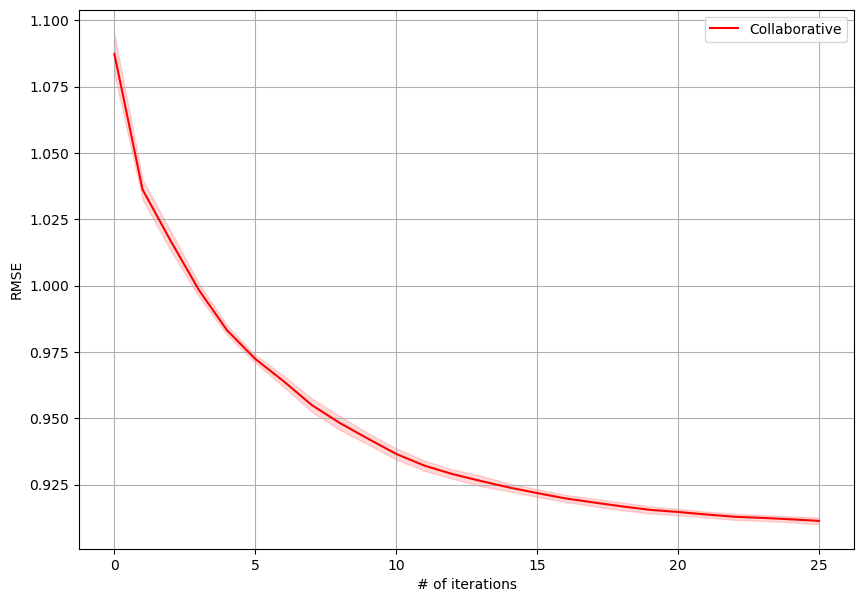

In [196]:
fig, ax = plt.subplots(figsize=(10,7))


strtg_rmse_df_grouped = rmse_df_grouped[rmse_df_grouped.strtg == 'MaxRating']
x = strtg_rmse_df_grouped['index']
ax.plot(x, strtg_rmse_df_grouped['mean'], color='r', label='Collaborative')
ax.fill_between(
        x, strtg_rmse_df_grouped['ci_lower'], strtg_rmse_df_grouped['ci_upper'], color='r', alpha=.15)


ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE')

In [197]:
pro_df = []
unpro_df = []
for results in all_results:
    for strtg in results:
        strtg_result = results[strtg]
        
        strtg_pro_df = pd.DataFrame(strtg_result['rmse_pro'], columns=['rmse_pro'])
        strtg_pro_df['strtg'] = strtg
        pro_df.append(strtg_pro_df)

        strtg_unpro_df = pd.DataFrame(strtg_result['rmse_unpro'], columns=['rmse_unpro'])
        strtg_unpro_df['strtg'] = strtg
        unpro_df.append(strtg_unpro_df)

pro_df = pd.concat(pro_df)
pro_df = pro_df.reset_index()
pro_df_grouped = pro_df.groupby(['index', 'strtg']).agg(['mean', 'std', 'count'])
pro_df_grouped = pro_df_grouped.droplevel(axis=1, level=0).reset_index()

pro_df_grouped['ci'] = 1.95 * pro_df_grouped['std'] / np.sqrt(pro_df_grouped['count'])
pro_df_grouped['ci_lower'] = pro_df_grouped['mean'] - pro_df_grouped['ci']
pro_df_grouped['ci_upper'] = pro_df_grouped['mean'] + pro_df_grouped['ci']
pro_df_grouped.head()

,index,strtg,mean,std,count,ci,ci_lower,ci_upper
0,0,MaxRating,1.125765,0.008419,5,0.007342,1.118423,1.133107
1,0,MinRating,1.125765,0.008419,5,0.007342,1.118423,1.133107
2,0,MixedRating,1.125765,0.008419,5,0.007342,1.118423,1.133107
3,0,Random,1.125765,0.008419,5,0.007342,1.118423,1.133107
4,1,MaxRating,1.073888,0.010291,5,0.008974,1.064914,1.082862


In [198]:
unpro_df = pd.concat(unpro_df)
unpro_df = unpro_df.reset_index()
unpro_df_grouped = unpro_df.groupby(['index', 'strtg']).agg(['mean', 'std', 'count'])
unpro_df_grouped = unpro_df_grouped.droplevel(axis=1, level=0).reset_index()

unpro_df_grouped['ci'] = 1.95 * unpro_df_grouped['std'] / np.sqrt(unpro_df_grouped['count'])
unpro_df_grouped['ci_lower'] = unpro_df_grouped['mean'] - unpro_df_grouped['ci']
unpro_df_grouped['ci_upper'] = unpro_df_grouped['mean'] + unpro_df_grouped['ci']
unpro_df_grouped.head()

,index,strtg,mean,std,count,ci,ci_lower,ci_upper
0,0,MaxRating,1.073658,0.010428,5,0.009094,1.064565,1.082752
1,0,MinRating,1.073658,0.010428,5,0.009094,1.064565,1.082752
2,0,MixedRating,1.073658,0.010428,5,0.009094,1.064565,1.082752
3,0,Random,1.073658,0.010428,5,0.009094,1.064565,1.082752
4,1,MaxRating,1.022863,0.004466,5,0.003894,1.018968,1.026757


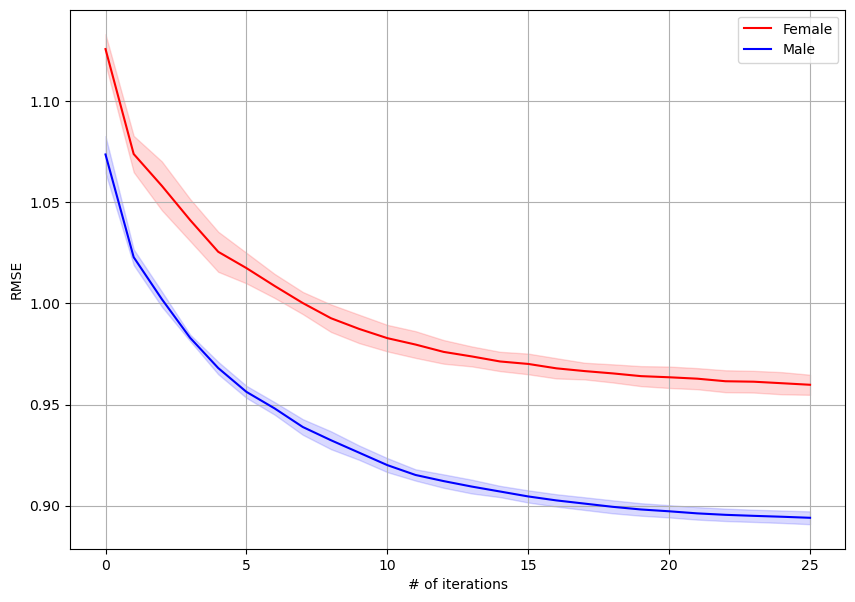

In [199]:
fig, ax = plt.subplots(figsize=(10,7))

y_axis = list(range(0, dataset.item_n, w))


strtg_pro_df_grouped = pro_df_grouped[pro_df_grouped.strtg == 'MaxRating']
x = strtg_pro_df_grouped['index']
ax.plot(x, strtg_pro_df_grouped['mean'], 'r', label='Female')
ax.fill_between(
        x, strtg_pro_df_grouped['ci_lower'], strtg_pro_df_grouped['ci_upper'], color='r', alpha=.15)

strtg_unpro_df_grouped = unpro_df_grouped[unpro_df_grouped.strtg == 'MaxRating']
x = strtg_unpro_df_grouped['index']
ax.plot(x, strtg_unpro_df_grouped['mean'], 'b', label='Male')
ax.fill_between(
        x, strtg_unpro_df_grouped['ci_lower'], strtg_unpro_df_grouped['ci_upper'], color='b', alpha=.15)
# ax.set_ylim(ymin=0)

ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE')

plt.savefig('./plots/proUnpro_rmse.png', dpi=300)

In [200]:
pro_df = []
unpro_df = []
for results in all_results:
    for strtg in results:
        strtg_result = results[strtg]
        
        strtg_pro_df = pd.DataFrame(strtg_result['c_pro'], columns=['c_pro'])
        strtg_pro_df['strtg'] = strtg
        pro_df.append(strtg_pro_df)

        strtg_unpro_df = pd.DataFrame(strtg_result['c_unpro'], columns=['c_unpro'])
        strtg_unpro_df['strtg'] = strtg
        unpro_df.append(strtg_unpro_df)

pro_df = pd.concat(pro_df)
pro_df = pro_df.reset_index()
pro_df_grouped = pro_df.groupby(['index', 'strtg']).agg(['mean', 'std', 'count'])
pro_df_grouped = pro_df_grouped.droplevel(axis=1, level=0).reset_index()

pro_df_grouped['ci'] = 1.95 * pro_df_grouped['std'] / np.sqrt(pro_df_grouped['count'])
pro_df_grouped['ci_lower'] = pro_df_grouped['mean'] - pro_df_grouped['ci']
pro_df_grouped['ci_upper'] = pro_df_grouped['mean'] + pro_df_grouped['ci']
pro_df_grouped.head()

,index,strtg,mean,std,count,ci,ci_lower,ci_upper
0,0,MaxRating,546.0,0.0,5,0.0,546.0,546.0
1,0,MinRating,546.0,0.0,5,0.0,546.0,546.0
2,0,MixedRating,546.0,0.0,5,0.0,546.0,546.0
3,0,Random,546.0,0.0,5,0.0,546.0,546.0
4,1,MaxRating,3276.0,0.0,5,0.0,3276.0,3276.0


In [201]:
unpro_df = pd.concat(unpro_df)
unpro_df = unpro_df.reset_index()
unpro_df_grouped = unpro_df.groupby(['index', 'strtg']).agg(['mean', 'std', 'count'])
unpro_df_grouped = unpro_df_grouped.droplevel(axis=1, level=0).reset_index()

unpro_df_grouped['ci'] = 1.95 * unpro_df_grouped['std'] / np.sqrt(unpro_df_grouped['count'])
unpro_df_grouped['ci_lower'] = unpro_df_grouped['mean'] - unpro_df_grouped['ci']
unpro_df_grouped['ci_upper'] = unpro_df_grouped['mean'] + unpro_df_grouped['ci']
unpro_df_grouped.head()

,index,strtg,mean,std,count,ci,ci_lower,ci_upper
0,0,MaxRating,1340.0,0.0,5,0.0,1340.0,1340.0
1,0,MinRating,1340.0,0.0,5,0.0,1340.0,1340.0
2,0,MixedRating,1340.0,0.0,5,0.0,1340.0,1340.0
3,0,Random,1340.0,0.0,5,0.0,1340.0,1340.0
4,1,MaxRating,8040.0,0.0,5,0.0,8040.0,8040.0


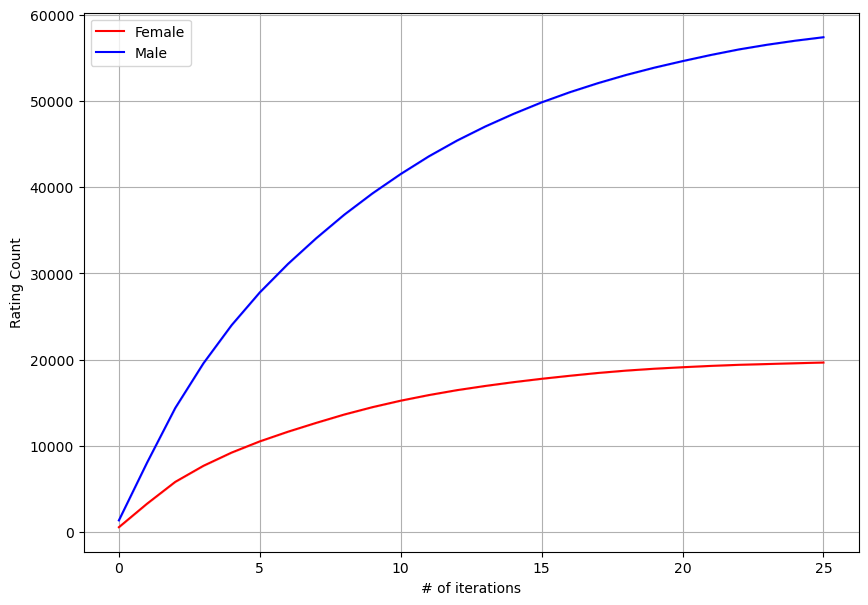

In [202]:
fig, ax = plt.subplots(figsize=(10,7))

y_axis = list(range(0, dataset.item_n, w))


strtg_pro_df_grouped = pro_df_grouped[pro_df_grouped.strtg == 'MaxRating']
x = strtg_pro_df_grouped['index']
ax.plot(x, strtg_pro_df_grouped['mean'], 'r', label='Female')
ax.fill_between(
        x, strtg_pro_df_grouped['ci_lower'], strtg_pro_df_grouped['ci_upper'], color='r', alpha=.15)

strtg_unpro_df_grouped = unpro_df_grouped[unpro_df_grouped.strtg == 'MaxRating']
x = strtg_unpro_df_grouped['index']
ax.plot(x, strtg_unpro_df_grouped['mean'], 'b', label='Male')
ax.fill_between(
        x, strtg_unpro_df_grouped['ci_lower'], strtg_unpro_df_grouped['ci_upper'], color='b', alpha=.15)
# ax.set_ylim(ymin=0)

ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('Rating Count')

plt.savefig('./plots/proUnpro_count.png', dpi=300)